In [ ]:
pip install earthpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.1 MB/s eta 0:00:00


In [ ]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch import nn
from torch import optim
import seaborn as sns
import time
import copy
sns.set()

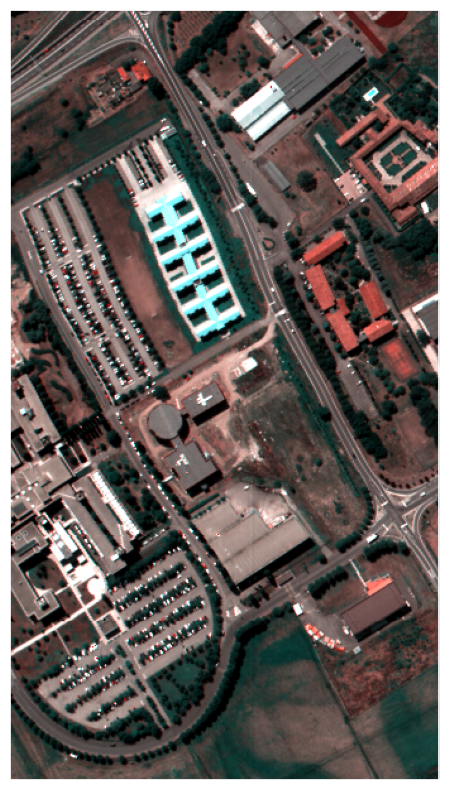

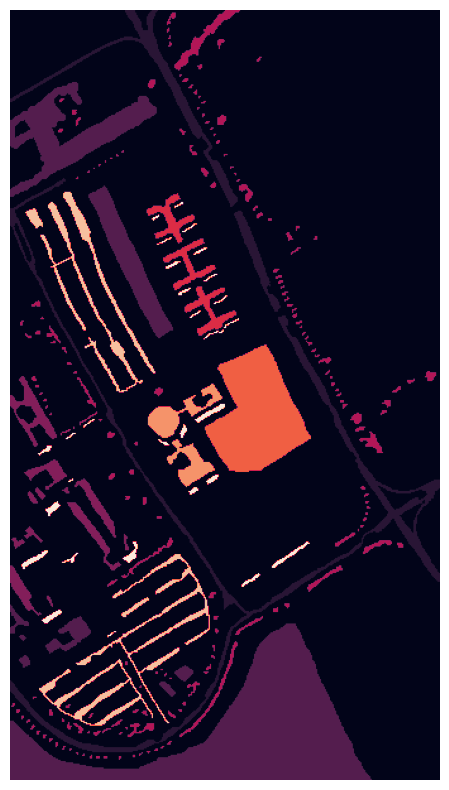

In [ ]:
data = loadmat('PaviaU.mat')['paviaU']
gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df = df[df['class']!=0]

stacked_bands = np.transpose(data, (2, 0, 1))
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]])
bands = [f'Band {i}' for i in range(1, 102, 50)]
colors = list(mcolors.BASE_COLORS)

epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
)
plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.axis('off')
plt.show()

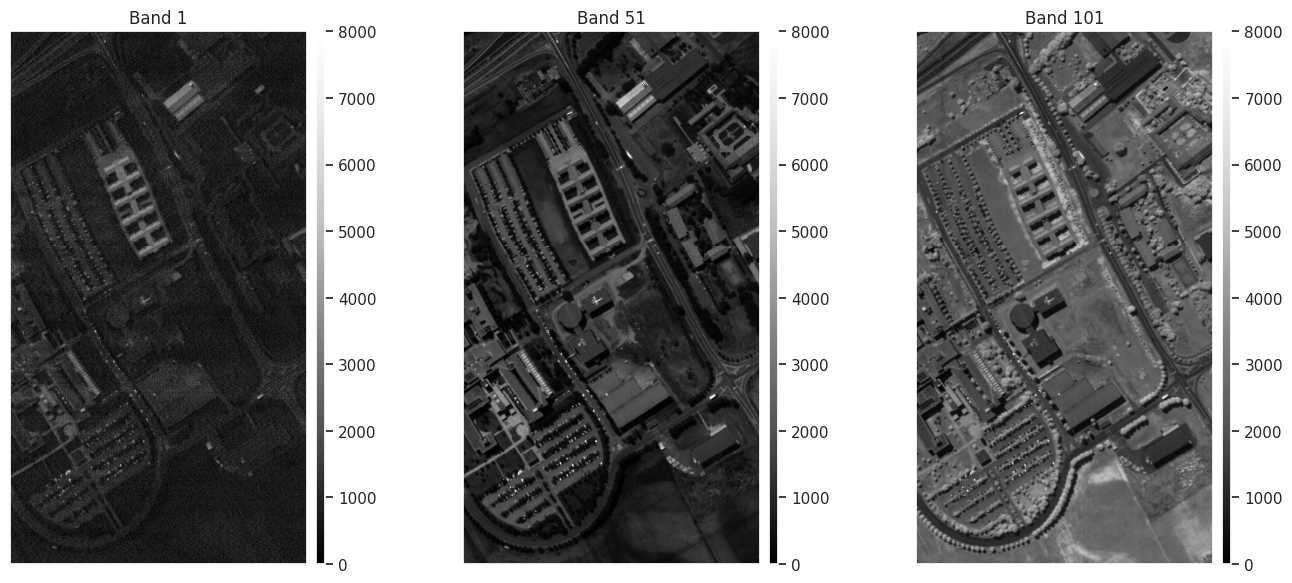

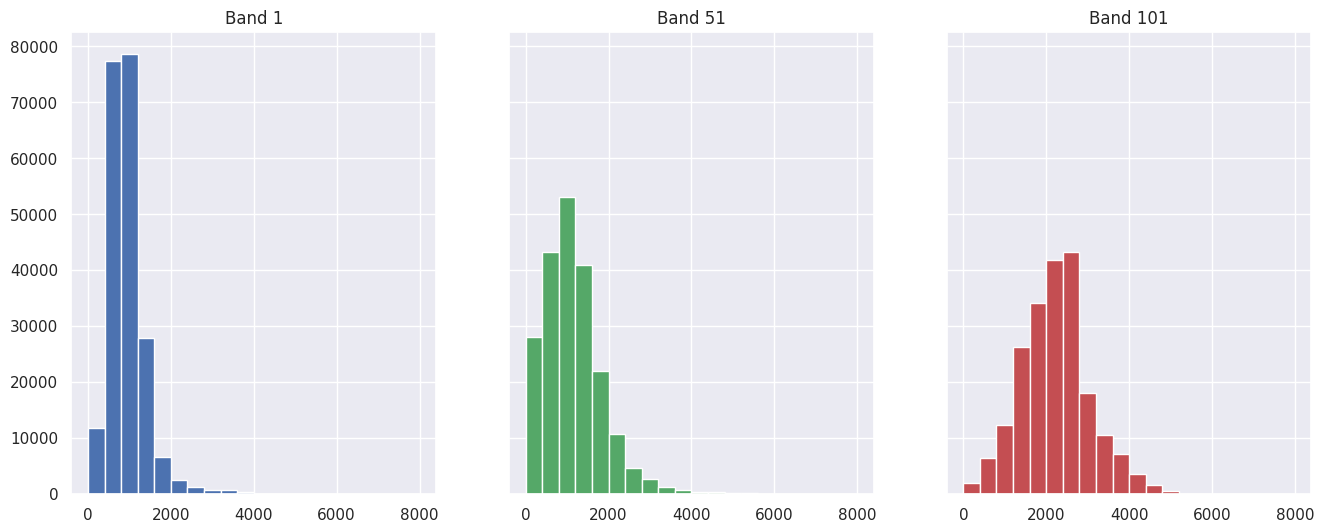

In [ ]:
epp.plot_bands(sampled_bands, title=bands, figsize= (14, 6))
epp.hist(sampled_bands, colors = colors,
         title=bands, cols=3, figsize = (16, 6))
plt.show()

Accuracy Score:  87.8 %


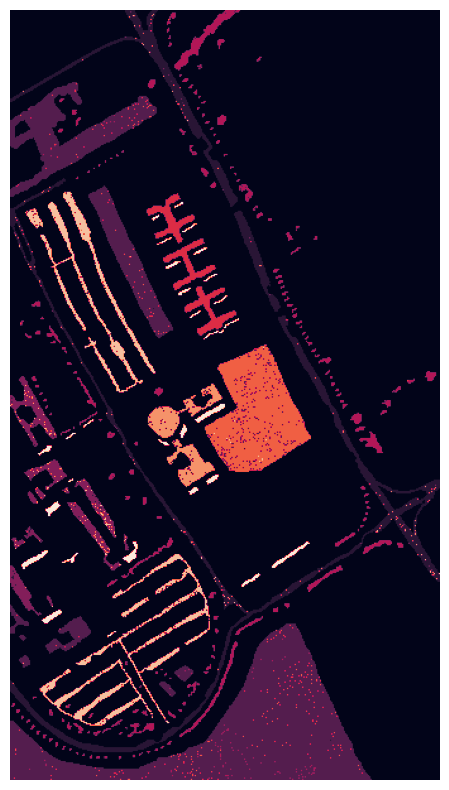

In [ ]:
x = df.drop(['class'], axis=1)
y = df['class']

le = preprocessing.LabelEncoder()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y)
y_encoder = le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(x_train.values, y_train)
print("Accuracy Score: ", round(accuracy_score(model.predict(x_test.values), y_test), 3)*100, "%")

l = []
for i in range(data.shape[0]*data.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model.predict([df.loc[i, :][:-1]])))
    else:
        l.append(0)

pred = np.array(l, dtype=object).reshape(gt.shape).astype('float')

plt.figure(figsize=(10, 10))
plt.imshow(pred)
plt.axis('off')
plt.show()

In [ ]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

In [ ]:
dimensions = 17
window_size = 25
pca = PCA(n_components=dimensions)
test_perc = 0.3

x = np.reshape(data, (-1, data.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (data.shape[0], data.shape[1], dimensions))
cnn_x, cnn_y = create_image(torch.tensor(x_pca.astype(np.float32)), gt, window_size=window_size)
# number of items in batch, number of channels, number of images in sequence, height of image, width of image
cnn_x = torch.permute(cnn_x[:, None, :, :, :], (0, 1, 4, 2, 3))
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x, cnn_y, test_size=test_perc, stratify=cnn_y)

train = data_utils.TensorDataset(cnn_x_train, cnn_y_train)
trainloader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
test = data_utils.TensorDataset(cnn_x_test, cnn_y_test)
testloader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4]))
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Test Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training/Test Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Test accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training/Test Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

Training complete in 54m 45s
Best val Acc: 0.962674
Best val Loss: 0.200284


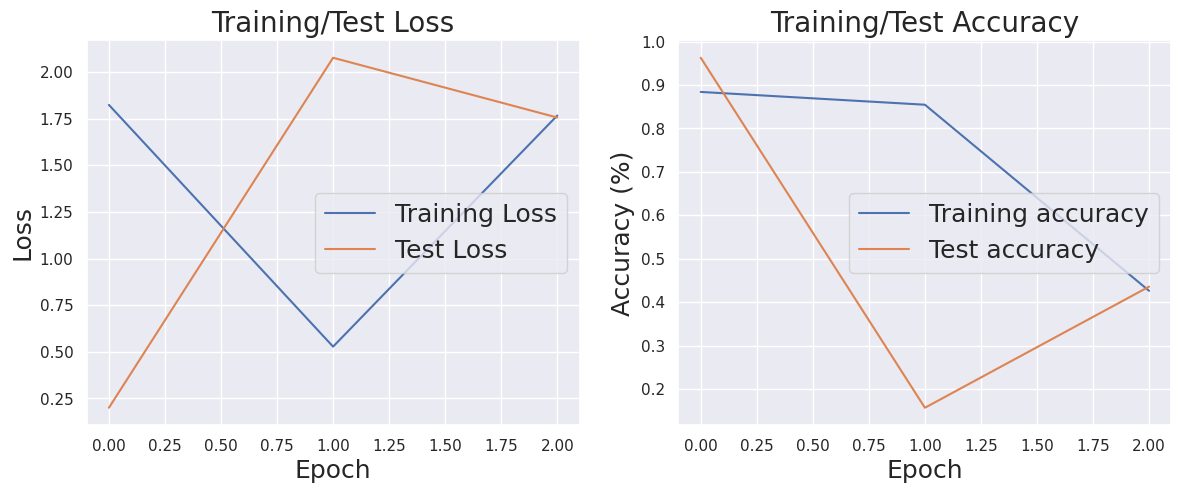

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
model = CNNModel(9)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=3)

In [ ]:
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data,
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues',
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.show()

def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

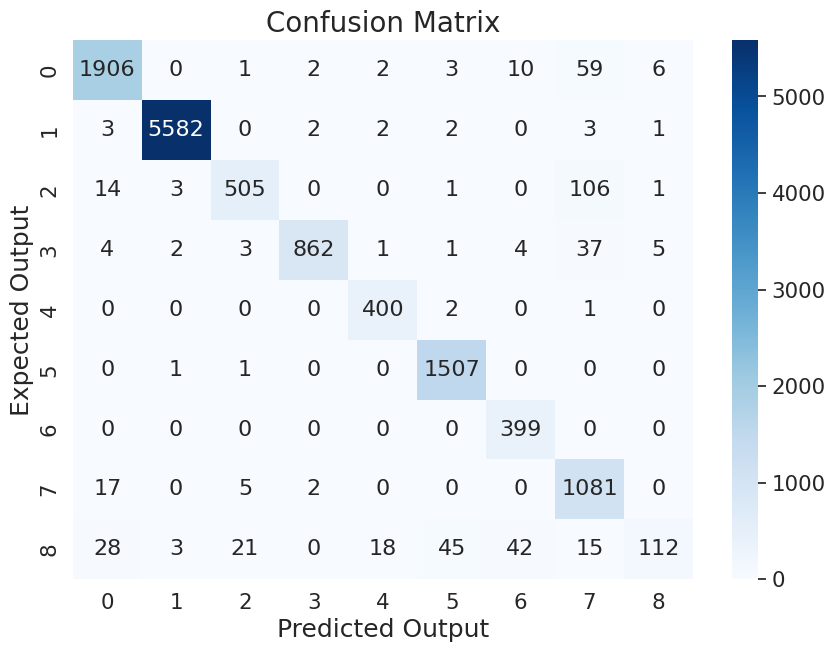

Class: 0 Accuracy: 95.82705
Class: 1 Accuracy: 99.76765
Class: 2 Accuracy: 80.15873
Class: 3 Accuracy: 93.79761
Class: 4 Accuracy: 99.255585
Class: 5 Accuracy: 99.86746
Class: 6 Accuracy: 100.0
Class: 7 Accuracy: 97.82806
Class: 8 Accuracy: 39.43662
Overall Accuracy:  89.54875 %


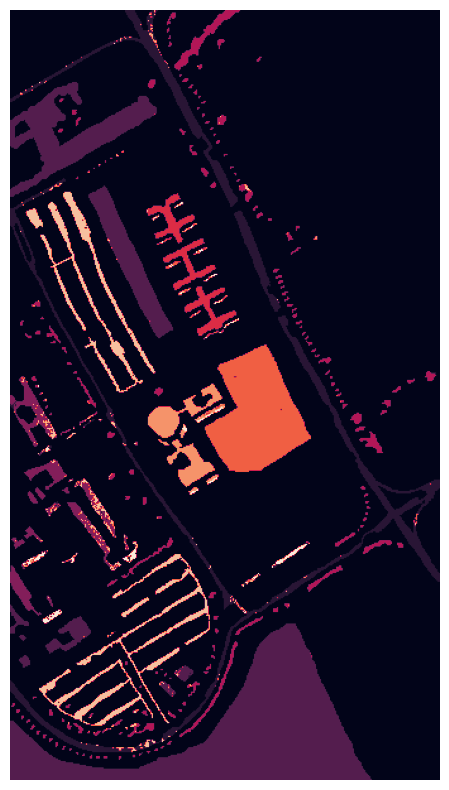

In [ ]:
x = np.reshape(data, (-1, data.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (data.shape[0], data.shape[1], dimensions))
padded_x = zeros_pad(torch.tensor(x_pca), window_size//2)

pred = np.zeros((gt.shape[0], gt.shape[1]))
for h in range(gt.shape[0]):
    for w in range(gt.shape[1]):
        if int(gt[h, w]) == 0:
            continue
        else:
            model.eval()
            image_patch = padded_x[h:h+window_size, w:w+window_size, :]
            image = torch.permute(image_patch[None, None, :, :, :], (0, 1, 4, 2, 3))
            pred[h][w] = model(image).argmax(dim=1) + 1

acc_per_class(model, testloader, 9)

plt.figure(figsize=(10, 10))
plt.imshow(pred)
plt.axis('off')
plt.show()

In [ ]:
#Predicting Crop Yields using Satellite Imagery
#An example of multi-level applications can instead be Crop Yields prediction.
#In this sort of use case, we aim to predict crop yields (e.g., corn, wheat)
#in agriculture fields before harvest time to enable better planning and decision-making for farmers
#to make these sorts of predictions accurately image data might in fact not be enough and other sources of information
#such as measurements of rainfalls, temperatures, gps coordinates, etc. are vital in order to make accurate predictions.

In [ ]:
#Data Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

df = pd.read_csv('yield_df.csv')
df = df.iloc[: , 1:]
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


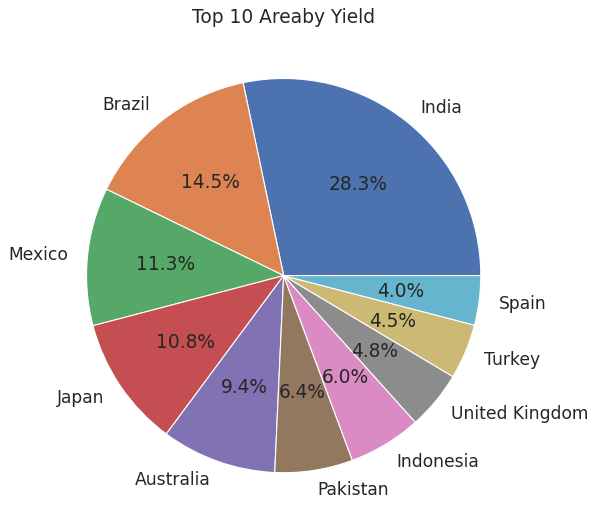

In [ ]:
# dataset contains crop data from a large number of countries with India covering on its own 28.3% of the available data.
def plot_pie(col):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=80)
    plt.title("Top 10 " + col + "by Yield")
    top_col_by_yield = df.groupby([col],sort=True)['hg/ha_yield'].sum().nlargest(10)
    ax.pie(top_col_by_yield.values, labels=top_col_by_yield.index, autopct='%1.1f%%')
    plt.show()

plot_pie('Area')

R2 Score: 0.9482198518196343


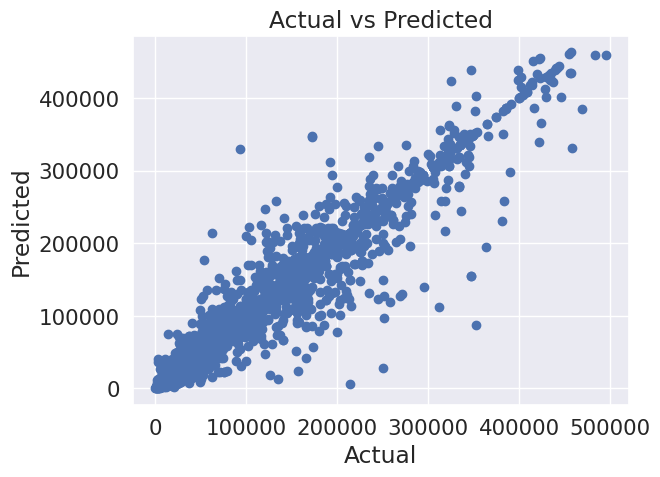

In [ ]:
# Model Creation
#divide our dataset into training and test sets and train a Decision Regressor model. In this case, R^2 has been selected as our metric of choice

sc = StandardScaler()
pca = PCA(n_components=50)

df = pd.get_dummies(df, columns=['Area', "Item"])
x = df.drop(['hg/ha_yield', 'Year'], axis=1)
y = df['hg/ha_yield']
x.head()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

scaler = sc.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
fitted_pca = pca.fit(x_train)
x_train = fitted_pca.transform(x_train)
x_test = fitted_pca.transform(x_test)

model = DecisionTreeRegressor()
model.fit(x_train , y_train)
y_pred = model.predict(x_test)
print("R2 Score:", r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()